In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from matplotlib.colors import to_rgba

# Darken color utility
def darken(color, factor=0.6):
    r, g, b, a = to_rgba(color)
    return (r * factor, g * factor, b * factor, a)

# Unified Step Grouping Definitions
common_group1_steps = [
    "Aggregate BLS keys", "Aggregate BLS signatures", "Generate N PoOs",
    "Generate VC payload", "Sign with N issuer", "Create final VC",
    "JWTProof2020Create", "EIP712Proof2021Create", "Issue VCs"
]
common_group2_steps = [
    "Store VC", "Create VP",
    "JWTProof2020Present", "EIP712Proof2021Present",
    "Store VCs", "Create VP (N VCs)"
]
common_group3_steps = [
    "Verify VP", "BLS Signature Verification",
    "DID Documents Resolution", "Proofs of Ownership Verification",
    "JWTProof2020Verify", "EIP712Proof2021Verify",
    "Verify VP (N VCs)", "Verify VCs"
]

def classify_step(step):
    if step in common_group1_steps:
        return "Issuing"
    elif step in common_group2_steps:
        return "Store & Present"
    elif step in common_group3_steps:
        return "Verification"
    return "Other"

# Unified Color Palette - using a combination of tab20 and tab10 for more distinct colors
all_common_steps = sorted(list(set(common_group1_steps + common_group2_steps + common_group3_steps)))

# Get 20 colors from tab20 and remaining from tab10 to ensure distinctness for 23 steps
colors_tab20 = [matplotlib.colormaps['tab20'](i) for i in np.linspace(0, 1, 20)]
colors_tab10 = [matplotlib.colormaps['tab10'](i) for i in np.linspace(0, 1, 10)]

# Combine to get enough distinct colors (20 from tab20 + 3 from tab10)
common_colors = colors_tab20 + colors_tab10[:(len(all_common_steps) - len(colors_tab20))]

common_step_colors = {step: common_colors[i] for i, step in enumerate(all_common_steps)}

# Explicitly assign highly distinguishable colors to specific steps
common_step_colors['Create VP'] = 'darkred'
common_step_colors['Verify VP'] = 'darkgreen'
common_step_colors['Verify VP (N VCs)'] = 'purple'

In [4]:
import pandas as pd

# Load the potential MultiSignature benchmark file for 16 claims
df_multi_16 = pd.read_csv('/content/benchmark_results_claims16_size64.csv')
# Load JwtProof2020 benchmark file for 16 claims
df_jwt_16 = pd.read_csv('/content/benchmark_standard_claims16_size64.csv')
# Load EIP712 benchmark file for 16 claims
df_eip_16 = pd.read_csv('/content/benchmark_standard_eip712_claims16_size64.csv')

# Load MultiSignature benchmark file for 128 claims
df_multi_128 = pd.read_csv('/content/benchmark_results_claims128_size64.csv')
# Load JwtProof2020 benchmark file for 128 claims
df_jwt_128 = pd.read_csv('/content/benchmark_standard_claims128_size64.csv')
# Load EIP712 benchmark file for 128 claims
df_eip_128 = pd.read_csv('/content/benchmark_standard_eip712_claims128_size64.csv')

print("Head of MultiIssVC/Benchmark Results data (df_multi_16):")
display(df_multi_16.head())

print("\nUnique StepNames in df_multi_16:")
display(df_multi_16['StepName'].unique())

Head of MultiIssVC/Benchmark Results data (df_multi_16):


,Issuers,StepName,avg_ms,std_ms
0,2,Aggregate BLS keys,1.362488,0.266545
1,2,Generate VC payload,0.090328,0.047227
2,2,Sign with N issuer,15.335095,2.542244
3,2,Generate N PoOs,9.500162,2.145429
4,2,Create final VC,5.242757,1.144243



Unique StepNames in df_multi_16:


array(['Aggregate BLS keys', 'Generate VC payload', 'Sign with N issuer',
       'Generate N PoOs', 'Create final VC', 'Store VC', 'Create VP',
       'Verify VP', 'BLS Signature Verification',
       'DID DocumentS Resolution', 'Proofs of Ownership Verification'],
      dtype=object)

## Small Size VC (16 Claims)

### MultiSignature (16 Claims) Plot

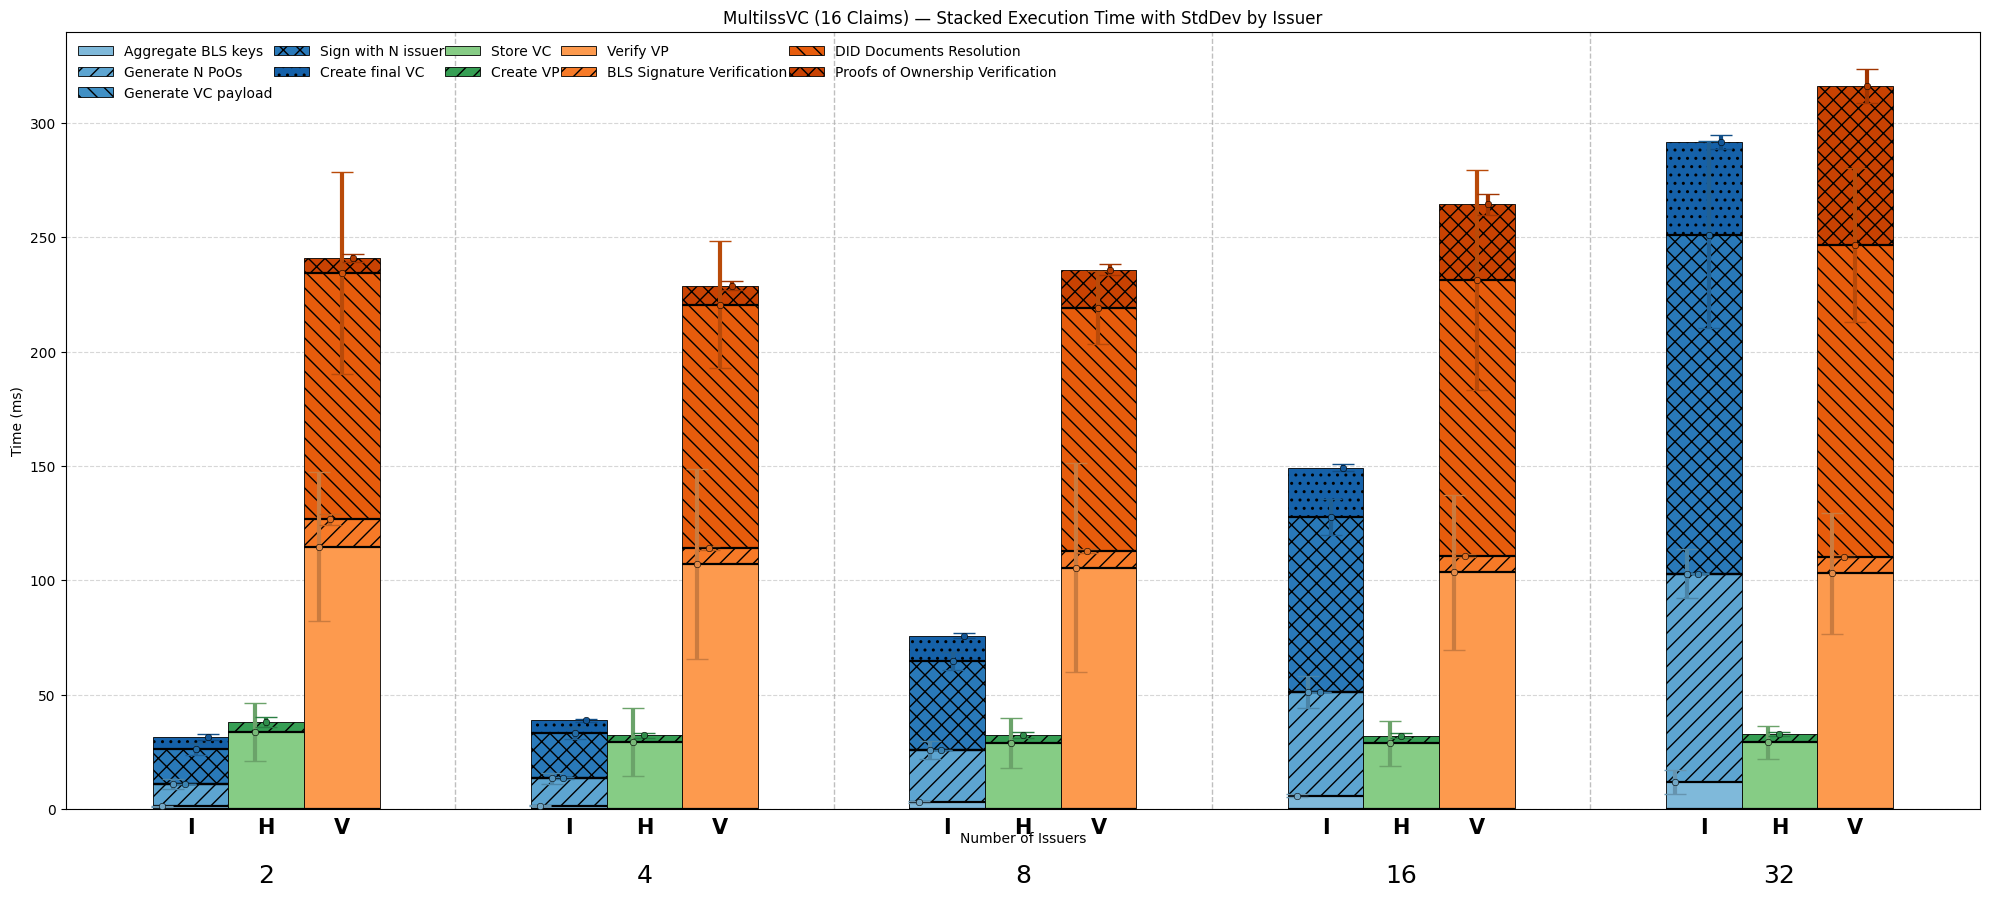

In [5]:
# --- Process and Plot MultiSignature Data (df_multi_16) ---

# =========================
# PREPROCESSING
# =========================

# Fix typos
df_multi_16["StepName"] = df_multi_16["StepName"].replace({
    "DID DocumentS Resolution": "DID Documents Resolution"
})

# Classify steps
df_multi_16["OperationGroup"] = df_multi_16["StepName"].apply(classify_step)

# Pivot avg and std_dev tables
avg_df = (
    df_multi_16
    .pivot_table(index="Issuers", columns="StepName", values="avg_ms", aggfunc="mean")
    .fillna(0)
    .sort_index()
)

std_df = (
    df_multi_16
    .pivot_table(index="Issuers", columns="StepName", values="std_ms", aggfunc="mean")
    .fillna(0)
    .sort_index()
)

# =========================
# GROUPING
# =========================

grouped_steps_multi = {
    "Issuing": [s for s in common_group1_steps if s in avg_df.columns],
    "Store & Present": [s for s in common_group2_steps if s in avg_df.columns],
    "Verification": [s for s in common_group3_steps if s in avg_df.columns]
}

# Actor-based gradient colormaps
actor_colormaps = {
    "Issuing": plt.cm.Blues,
    "Store & Present": plt.cm.Greens,
    "Verification": plt.cm.Oranges
}

# STEP-level hatch patterns
step_hatches = ["", "//", "\\\\", "xx", "..", "++"]

# =========================
# PLOTTING
# =========================

x_multi = np.arange(len(avg_df.index))
bar_width = 0.20
ci_offset = bar_width * 0.15

fig, ax = plt.subplots(figsize=(20, 9))

for i, (group_label, steps) in enumerate(grouped_steps_multi.items()):
    bottom = np.zeros(len(avg_df))
    offset = (i - 1) * bar_width
    cmap = actor_colormaps[group_label]
    n_steps = max(1, len(steps))

    for j, step in enumerate(steps):
        if step not in avg_df.columns:
            continue

        values = avg_df[step].values
        errors = std_df[step].values

        color = cmap(0.45 + 0.45 * (j / n_steps))
        hatch = step_hatches[j % len(step_hatches)]

        bars = ax.bar(
            x_multi + offset,
            values,
            bottom=bottom,
            width=bar_width,
            label=step,
            color=color,
            edgecolor="black",
            linewidth=0.6,
            hatch=hatch,
            zorder=3
        )

        # Highlight bar start
        for b in bars:
            ax.hlines(
                y=b.get_y(),
                xmin=b.get_x(),
                xmax=b.get_x() + b.get_width(),
                colors="black",
                linewidth=1.6,
                zorder=4
            )

        # StdDev error bars + dot at center
        for xi, btm, val, err in zip(x_multi, bottom, values, errors):
            x_err = xi + offset + (j - n_steps / 2) * ci_offset
            y_center = btm + val

            ax.errorbar(
                x_err,
                y_center,
                yerr=err,
                ecolor=darken(color, 0.8),
                capsize=8,
                fmt="none",
                elinewidth=3,
                zorder=5
            )

            ax.scatter(
                x_err,
                y_center,
                s=22,
                color=darken(color, 0.9),
                edgecolor="black",
                linewidth=0.4,
                zorder=6
            )

        bottom += values

# =========================
# CUSTOM X-AXIS
# =========================

ax.set_xticks([])
plt.subplots_adjust(bottom=0.1)
trans = ax.get_xaxis_transform()

actors = ["I", "H", "V"]
offsets = [-bar_width, 0.0, bar_width]

for xi in x_multi:
    for actor, off in zip(actors, offsets):
        ax.text(
            xi + off, -0.01, actor,
            transform=trans,
            ha="center", va="top",
            fontsize=15, fontweight="bold"
        )

for xi, label in zip(x_multi, avg_df.index.astype(str)):
    ax.text(
        xi, -0.1, label,
        transform=trans,
        ha="center", va="bottom",
        fontsize=18
    )

ax.set_xlabel("Number of Issuers", labelpad=16)

# =========================
# VERTICAL SEPARATORS
# =========================

for xi in x_multi[:-1]:
    ax.axvline(
        xi + 0.5,
        color="gray",
        linestyle="--",
        linewidth=1,
        alpha=0.5,
        zorder=1
    )

# =========================
# FINAL COSMETICS
# =========================

ax.set_ylabel("Time (ms)")
ax.set_title("MultiIssVC (16 Claims) — Stacked Execution Time with StdDev by Issuer")

ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.0, 1.0),
    ncol=5,
    columnspacing=0.1,
    handlelength=2.5,
    handletextpad=0.8,
    frameon=False
)

ax.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)

plt.tight_layout()
plt.show()


### JwtProof2020 (16 Claims) Plot

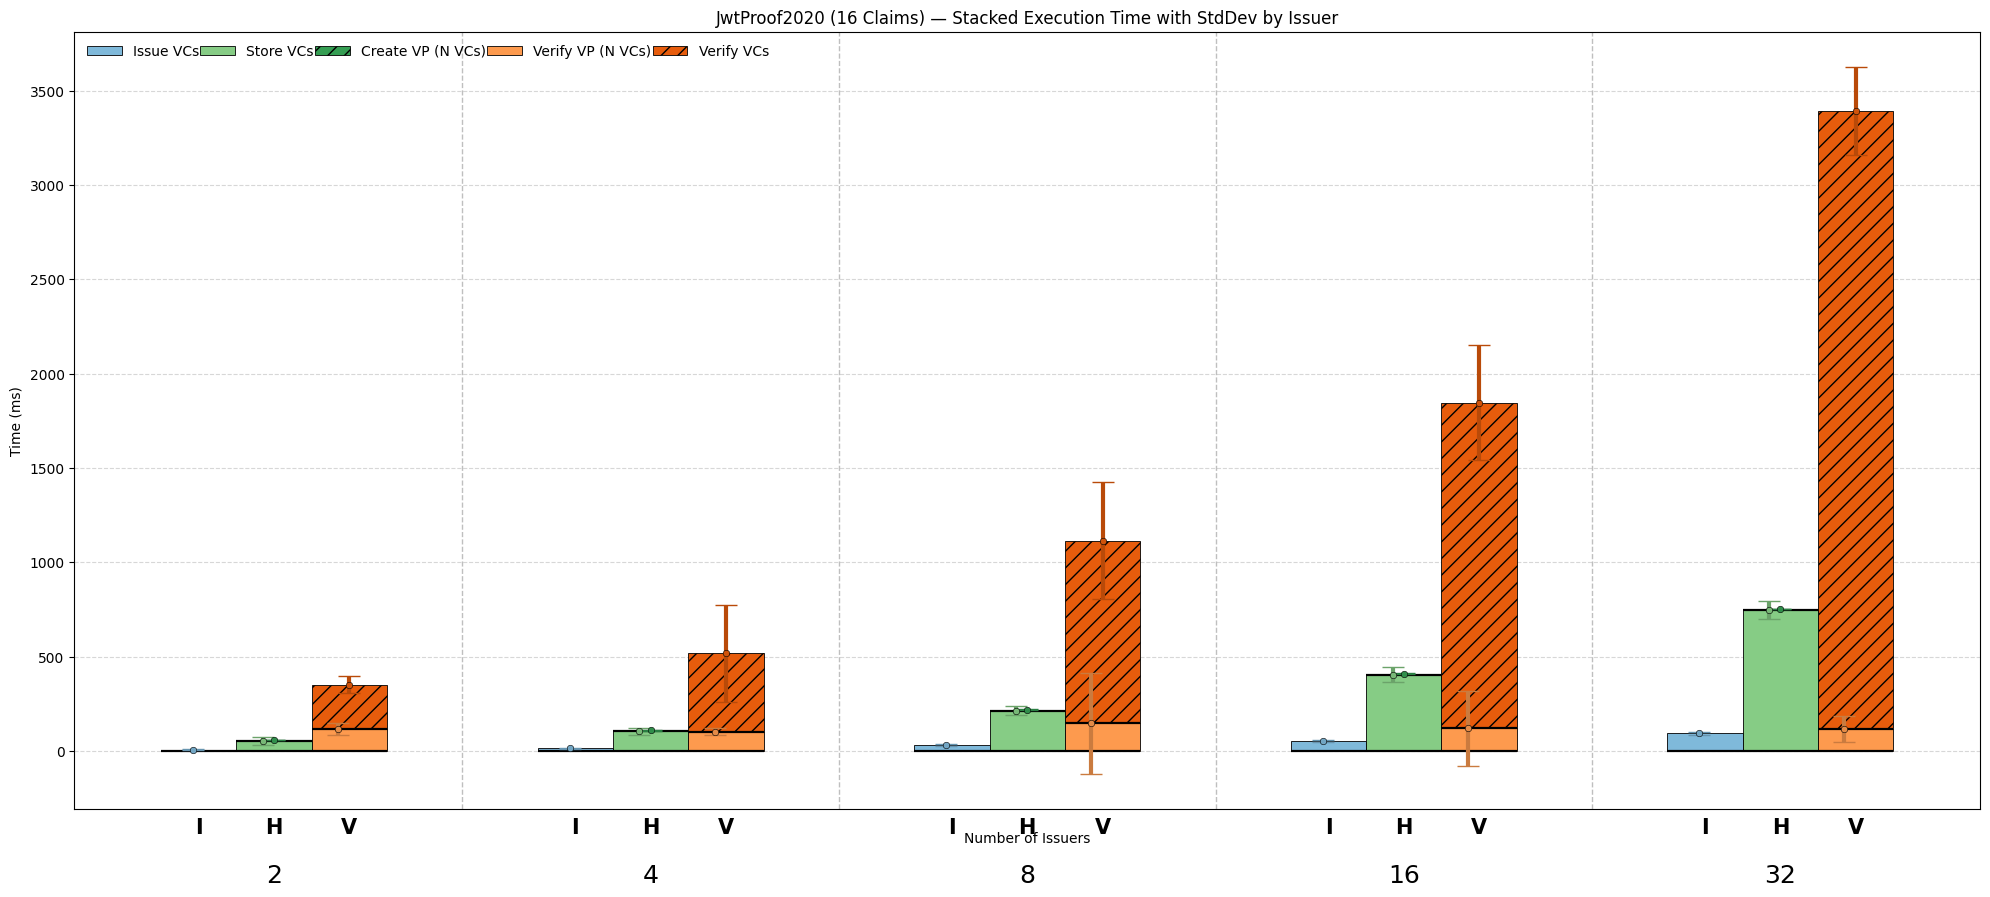

In [6]:
# --- Process and Plot JwtProof2020 Data (df_jwt_16) ---

# =========================
# PREPROCESSING
# =========================

df_jwt_16["OperationGroup"] = df_jwt_16["StepName"].apply(classify_step)

# Pivot avg and std_dev tables
avg_df = (
    df_jwt_16
    .pivot_table(index="Issuers", columns="StepName", values="avg_ms", aggfunc="mean")
    .fillna(0)
    .sort_index()
)

std_df = (
    df_jwt_16
    .pivot_table(index="Issuers", columns="StepName", values="std_ms", aggfunc="mean")
    .fillna(0)
    .sort_index()
)

# =========================
# GROUPING
# =========================

grouped_steps_jwt = {
    "Issuing": [s for s in common_group1_steps if s in avg_df.columns],
    "Store & Present": [s for s in common_group2_steps if s in avg_df.columns],
    "Verification": [s for s in common_group3_steps if s in avg_df.columns]
}

# Actor-based gradient colormaps
actor_colormaps = {
    "Issuing": plt.cm.Blues,
    "Store & Present": plt.cm.Greens,
    "Verification": plt.cm.Oranges
}

# STEP-level hatch patterns
step_hatches = ["", "//", "\\\\", "xx", "..", "++"]

# =========================
# PLOTTING
# =========================

x = np.arange(len(avg_df.index))
bar_width = 0.20
ci_offset = bar_width * 0.15

fig, ax = plt.subplots(figsize=(20, 9))

for i, (group_label, steps) in enumerate(grouped_steps_jwt.items()):
    bottom = np.zeros(len(avg_df))
    offset = (i - 1) * bar_width
    cmap = actor_colormaps[group_label]
    n_steps = max(1, len(steps))

    for j, step in enumerate(steps):
        if step not in avg_df.columns:
            continue

        values = avg_df[step].values
        errors = std_df[step].values

        color = cmap(0.45 + 0.45 * (j / n_steps))
        hatch = step_hatches[j % len(step_hatches)]

        bars = ax.bar(
            x + offset,
            values,
            bottom=bottom,
            width=bar_width,
            label=step,
            color=color,
            edgecolor="black",
            linewidth=0.6,
            hatch=hatch,
            zorder=3
        )

        # Highlight bar start
        for b in bars:
            ax.hlines(
                y=b.get_y(),
                xmin=b.get_x(),
                xmax=b.get_x() + b.get_width(),
                colors="black",
                linewidth=1.6,
                zorder=4
            )

        # StdDev error bars + dot at center
        for xi, btm, val, err in zip(x, bottom, values, errors):
            x_err = xi + offset + (j - n_steps / 2) * ci_offset
            y_center = btm + val

            ax.errorbar(
                x_err,
                y_center,
                yerr=err,
                ecolor=darken(color, 0.8),
                capsize=8,
                fmt="none",
                elinewidth=3,
                zorder=5
            )

            ax.scatter(
                x_err,
                y_center,
                s=22,
                color=darken(color, 0.9),
                edgecolor="black",
                linewidth=0.4,
                zorder=6
            )

        bottom += values

# =========================
# CUSTOM X-AXIS
# =========================

ax.set_xticks([])
plt.subplots_adjust(bottom=0.10)
trans = ax.get_xaxis_transform()

actors = ["I", "H", "V"]
offsets = [-bar_width, 0.0, bar_width]

for xi in x:
    for actor, off in zip(actors, offsets):
        ax.text(
            xi + off, -0.01, actor,
            transform=trans,
            ha="center", va="top",
            fontsize=15, fontweight="bold"
        )

for xi, label in zip(x, avg_df.index.astype(str)):
    ax.text(
        xi, -0.10, label,
        transform=trans,
        ha="center", va="bottom",
        fontsize=18
    )

ax.set_xlabel("Number of Issuers", labelpad=16)

# =========================
# VERTICAL SEPARATORS
# =========================

for xi in x[:-1]:
    ax.axvline(
        xi + 0.5,
        color="gray",
        linestyle="--",
        linewidth=1,
        alpha=0.5,
        zorder=1
    )

# =========================
# FINAL COSMETICS
# =========================

ax.set_ylabel("Time (ms)")
ax.set_title("JwtProof2020 (16 Claims) — Stacked Execution Time with StdDev by Issuer")

ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.0, 1.0),
    ncol=5,
    columnspacing=0.1,
    handlelength=2.5,
    handletextpad=0.8,
    frameon=False
)

ax.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)

plt.tight_layout()
plt.show()


### EIP712 (16 Claims) Plot

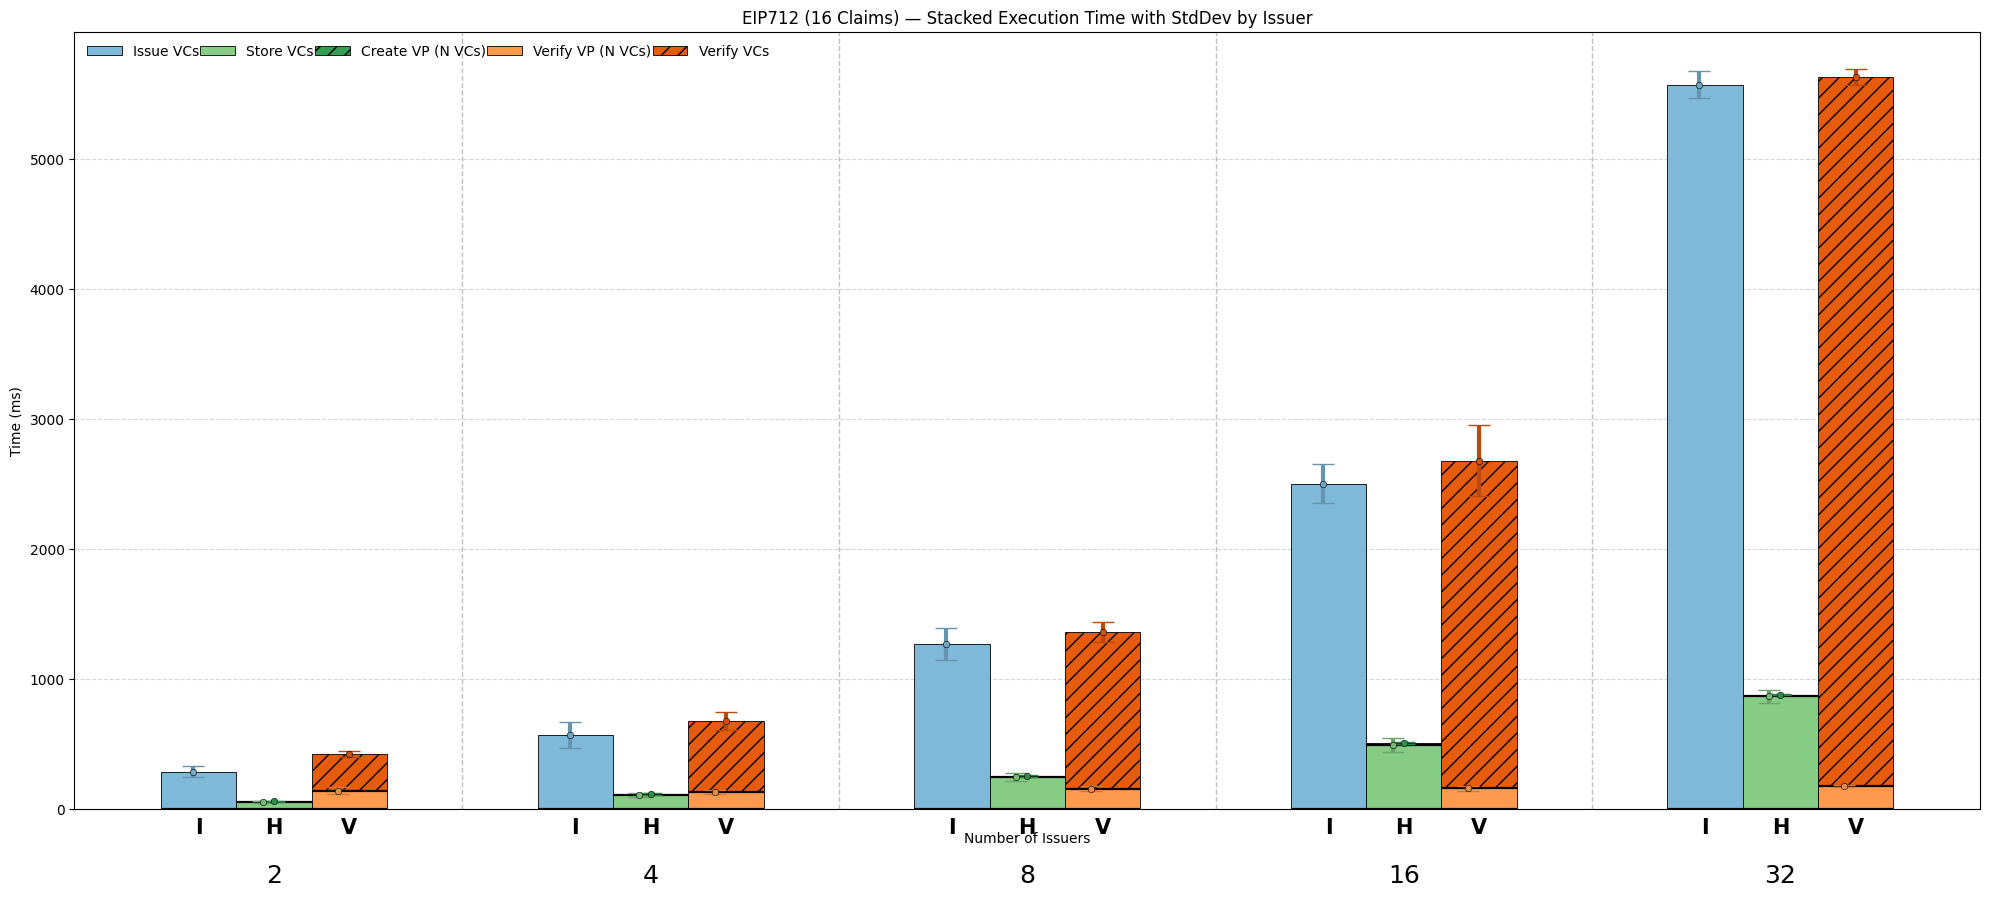

In [7]:
# --- Process and Plot EIP712 Data (df_eip_16) ---

# =========================
# PREPROCESSING
# =========================

df_eip_16["OperationGroup"] = df_eip_16["StepName"].apply(classify_step)

# Pivot avg and std_dev tables
avg_df = (
    df_eip_16
    .pivot_table(index="Issuers", columns="StepName", values="avg_ms", aggfunc="mean")
    .fillna(0)
    .sort_index()
)

std_df = (
    df_eip_16
    .pivot_table(index="Issuers", columns="StepName", values="std_ms", aggfunc="mean")
    .fillna(0)
    .sort_index()
)

# =========================
# GROUPING
# =========================

grouped_steps_eip = {
    "Issuing": [s for s in common_group1_steps if s in avg_df.columns],
    "Store & Present": [s for s in common_group2_steps if s in avg_df.columns],
    "Verification": [s for s in common_group3_steps if s in avg_df.columns]
}

# Actor-based gradient colormaps
actor_colormaps = {
    "Issuing": plt.cm.Blues,
    "Store & Present": plt.cm.Greens,
    "Verification": plt.cm.Oranges
}

# STEP-level hatch patterns
step_hatches = ["", "//", "\\\\", "xx", "..", "++"]

# =========================
# PLOTTING
# =========================

x = np.arange(len(avg_df.index))
bar_width = 0.20
ci_offset = bar_width * 0.15

fig, ax = plt.subplots(figsize=(20, 9))

for i, (group_label, steps) in enumerate(grouped_steps_eip.items()):
    bottom = np.zeros(len(avg_df))
    offset = (i - 1) * bar_width
    cmap = actor_colormaps[group_label]
    n_steps = max(1, len(steps))

    for j, step in enumerate(steps):
        if step not in avg_df.columns:
            continue

        values = avg_df[step].values
        errors = std_df[step].values

        color = cmap(0.45 + 0.45 * (j / n_steps))
        hatch = step_hatches[j % len(step_hatches)]

        bars = ax.bar(
            x + offset,
            values,
            bottom=bottom,
            width=bar_width,
            label=step,
            color=color,
            edgecolor="black",
            linewidth=0.6,
            hatch=hatch,
            zorder=3
        )

        # Highlight bar start
        for b in bars:
            ax.hlines(
                y=b.get_y(),
                xmin=b.get_x(),
                xmax=b.get_x() + b.get_width(),
                colors="black",
                linewidth=1.6,
                zorder=4
            )

        # StdDev error bars + dot at center
        for xi, btm, val, err in zip(x, bottom, values, errors):
            x_err = xi + offset + (j - n_steps / 2) * ci_offset
            y_center = btm + val

            ax.errorbar(
                x_err,
                y_center,
                yerr=err,
                ecolor=darken(color, 0.8),
                capsize=8,
                fmt="none",
                elinewidth=3,
                zorder=5
            )

            ax.scatter(
                x_err,
                y_center,
                s=22,
                color=darken(color, 0.9),
                edgecolor="black",
                linewidth=0.4,
                zorder=6
            )

        bottom += values

# =========================
# CUSTOM X-AXIS
# =========================

ax.set_xticks([])
plt.subplots_adjust(bottom=0.10)
trans = ax.get_xaxis_transform()

actors = ["I", "H", "V"]
offsets = [-bar_width, 0.0, bar_width]

# Actor labels (tight)
for xi in x:
    for actor, off in zip(actors, offsets):
        ax.text(
            xi + off, -0.01, actor,
            transform=trans,
            ha="center", va="top",
            fontsize=15, fontweight="bold"
        )

# Issuer numbers (close to xlabel)
for xi, label in zip(x, avg_df.index.astype(str)):
    ax.text(
        xi, -0.10, label,
        transform=trans,
        ha="center", va="bottom",
        fontsize=18
    )

ax.set_xlabel("Number of Issuers", labelpad=16)

# =========================
# VERTICAL SEPARATORS
# =========================

for xi in x[:-1]:
    ax.axvline(
        xi + 0.5,
        color="gray",
        linestyle="--",
        linewidth=1,
        alpha=0.5,
        zorder=1
    )

# =========================
# FINAL COSMETICS
# =========================

ax.set_ylabel("Time (ms)")
ax.set_title("EIP712 (16 Claims) — Stacked Execution Time with StdDev by Issuer")

ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.0, 1.0),
    ncol=5,
    columnspacing=0.1,
    handlelength=2.5,
    handletextpad=0.8,
    frameon=False
)

ax.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)

plt.tight_layout()
plt.show()


In [8]:
# Increase font sizes globally for research-article visibility
matplotlib.rcParams.update({
    'font.size': 18,               # base font size
    'axes.titlesize': 16,          # title font
    'axes.labelsize': 18,          # x/y label font
    'xtick.labelsize': 18,         # x-axis ticks
    'ytick.labelsize': 18,         # y-axis ticks
    'legend.fontsize': 16,         # legend text
    'legend.title_fontsize': 18,   # legend title (if used)
    'errorbar.capsize': 4
})

## Large Size VC (128 Claims)

### JwtProof2020 (128 Claims) Plot

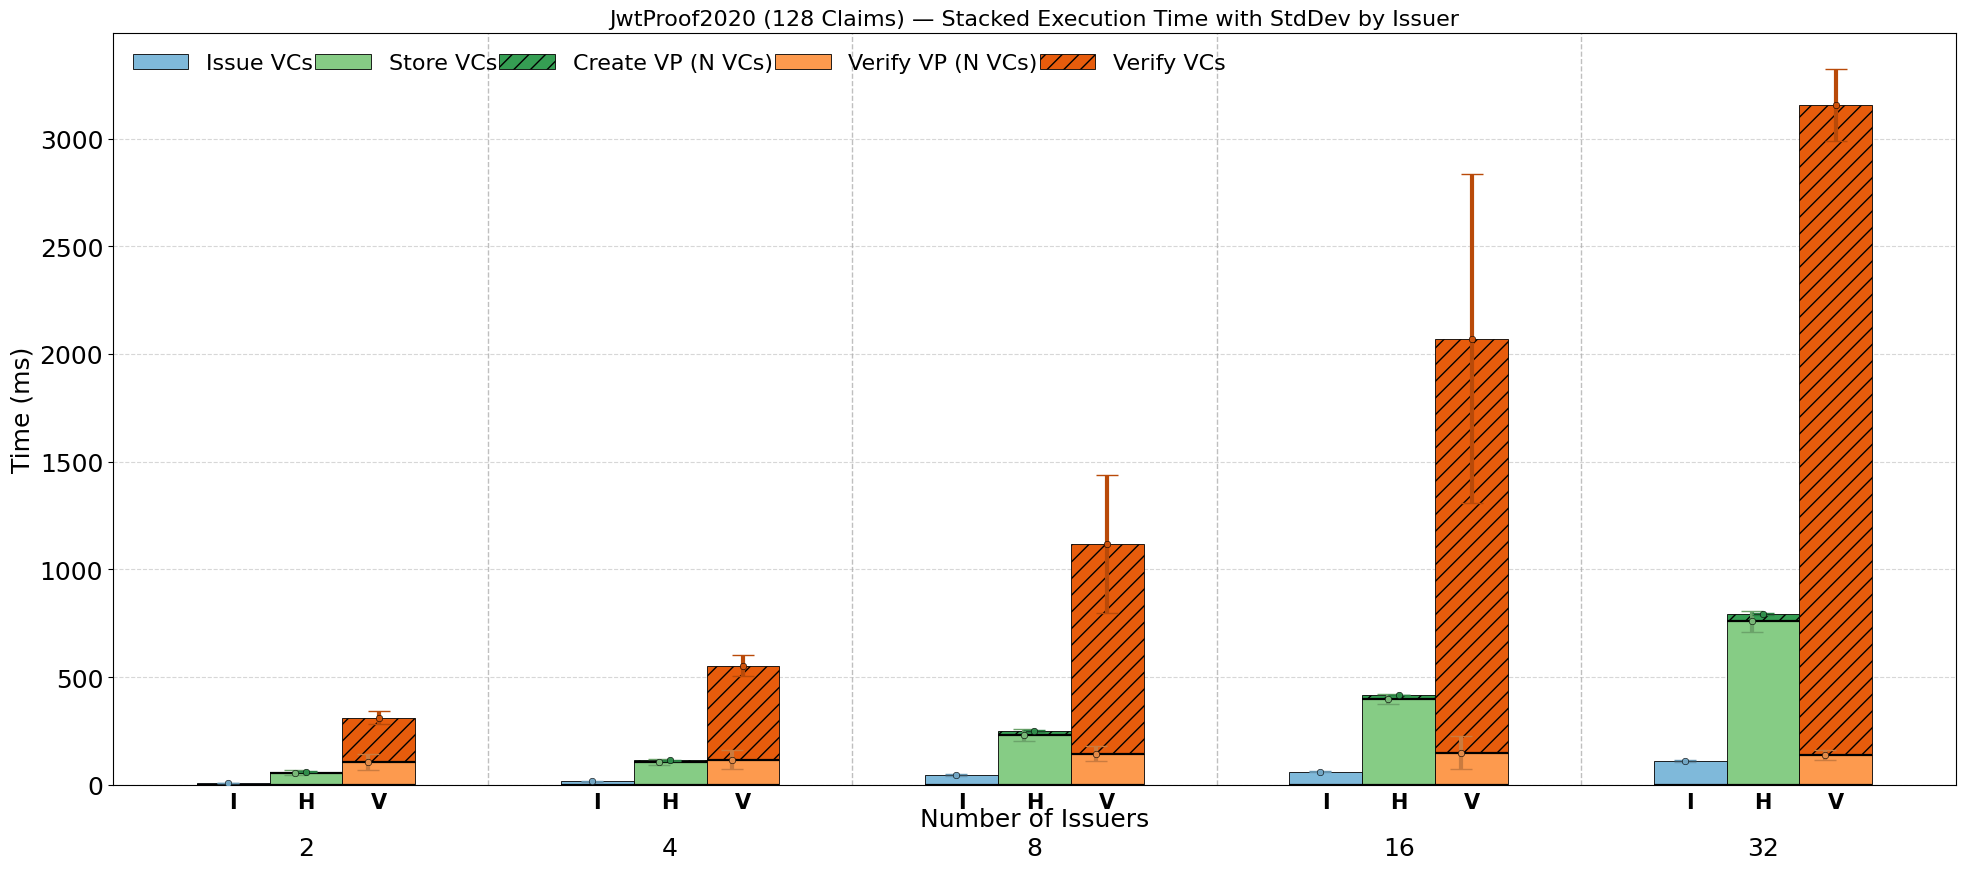

In [9]:
# --- Process and Plot JwtProof2020 Data (df_jwt_128) ---

# =========================
# PREPROCESSING
# =========================

df_jwt_128["OperationGroup"] = df_jwt_128["StepName"].apply(classify_step)

# Pivot avg and std_dev tables
avg_df = (
    df_jwt_128
    .pivot_table(index="Issuers", columns="StepName", values="avg_ms", aggfunc="mean")
    .fillna(0)
    .sort_index()
)

std_df = (
    df_jwt_128
    .pivot_table(index="Issuers", columns="StepName", values="std_ms", aggfunc="mean")
    .fillna(0)
    .sort_index()
)

# =========================
# GROUPING
# =========================

grouped_steps_jwt = {
    "Issuing": [s for s in common_group1_steps if s in avg_df.columns],
    "Store & Present": [s for s in common_group2_steps if s in avg_df.columns],
    "Verification": [s for s in common_group3_steps if s in avg_df.columns]
}

# Actor-based gradient colormaps
actor_colormaps = {
    "Issuing": plt.cm.Blues,
    "Store & Present": plt.cm.Greens,
    "Verification": plt.cm.Oranges
}

# STEP-level hatch patterns
step_hatches = ["", "//", "\\\\", "xx", "..", "++"]

# =========================
# PLOTTING
# =========================

x = np.arange(len(avg_df.index))
bar_width = 0.20
ci_offset = bar_width * 0.15

fig, ax = plt.subplots(figsize=(20, 9))

for i, (group_label, steps) in enumerate(grouped_steps_jwt.items()):
    bottom = np.zeros(len(avg_df))
    offset = (i - 1) * bar_width
    cmap = actor_colormaps[group_label]
    n_steps = max(1, len(steps))

    for j, step in enumerate(steps):
        if step not in avg_df.columns:
            continue

        values = avg_df[step].values
        errors = std_df[step].values

        color = cmap(0.45 + 0.45 * (j / n_steps))
        hatch = step_hatches[j % len(step_hatches)]

        bars = ax.bar(
            x + offset,
            values,
            bottom=bottom,
            width=bar_width,
            label=step,
            color=color,
            edgecolor="black",
            linewidth=0.6,
            hatch=hatch,
            zorder=3
        )

        # Highlight bar start
        for b in bars:
            ax.hlines(
                y=b.get_y(),
                xmin=b.get_x(),
                xmax=b.get_x() + b.get_width(),
                colors="black",
                linewidth=1.6,
                zorder=4
            )

        # StdDev error bars + dot at center
        for xi, btm, val, err in zip(x, bottom, values, errors):
            x_err = xi + offset + (j - n_steps / 2) * ci_offset
            y_center = btm + val

            ax.errorbar(
                x_err,
                y_center,
                yerr=err,
                ecolor=darken(color, 0.8),
                capsize=8,
                fmt="none",
                elinewidth=3,
                zorder=5
            )

            ax.scatter(
                x_err,
                y_center,
                s=22,
                color=darken(color, 0.9),
                edgecolor="black",
                linewidth=0.4,
                zorder=6
            )

        bottom += values

# =========================
# CUSTOM X-AXIS
# =========================

ax.set_xticks([])
plt.subplots_adjust(bottom=0.10)
trans = ax.get_xaxis_transform()

actors = ["I", "H", "V"]
offsets = [-bar_width, 0.0, bar_width]

for xi in x:
    for actor, off in zip(actors, offsets):
        ax.text(
            xi + off, -0.01, actor,
            transform=trans,
            ha="center", va="top",
            fontsize=15, fontweight="bold"
        )

for xi, label in zip(x, avg_df.index.astype(str)):
    ax.text(
        xi, -0.10, label,
        transform=trans,
        ha="center", va="bottom",
        fontsize=18
    )

ax.set_xlabel("Number of Issuers", labelpad=16)

# =========================
# VERTICAL SEPARATORS
# =========================

for xi in x[:-1]:
    ax.axvline(
        xi + 0.5,
        color="gray",
        linestyle="--",
        linewidth=1,
        alpha=0.5,
        zorder=1
    )

# =========================
# FINAL COSMETICS
# =========================

ax.set_ylabel("Time (ms)")
ax.set_title("JwtProof2020 (128 Claims) — Stacked Execution Time with StdDev by Issuer")

ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.0, 1.0),
    ncol=5,
    columnspacing=0.1,
    handlelength=2.5,
    handletextpad=0.8,
    frameon=False
)

ax.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)

plt.tight_layout()
plt.show()


### EIP712 (128 Claims) Plot

### MultiSignature (128 Claims) Plot

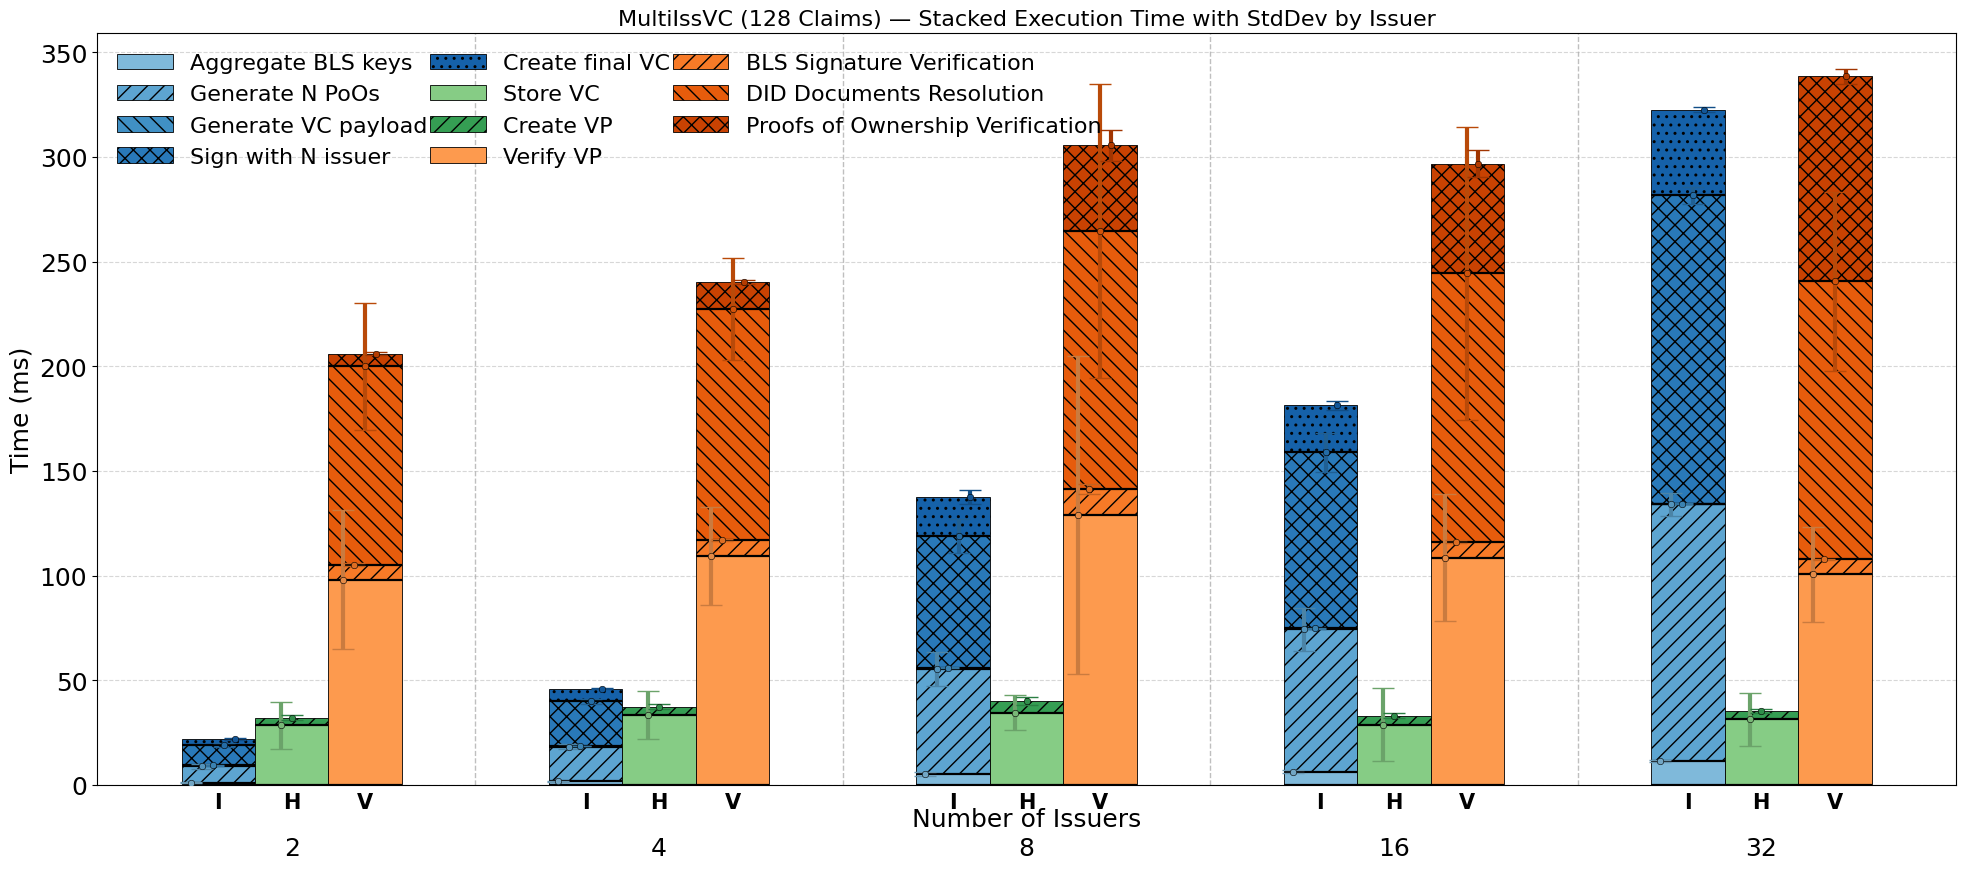

In [10]:
# --- Process and Plot MultiSignature Data (df_multi_128) ---

# =========================
# PREPROCESSING
# =========================

# Fix typos
df_multi_128["StepName"] = df_multi_128["StepName"].replace({
    "DID DocumentS Resolution": "DID Documents Resolution"
})

# Classify steps
df_multi_128["OperationGroup"] = df_multi_128["StepName"].apply(classify_step)

# Pivot avg and std_dev tables
avg_df = (
    df_multi_128
    .pivot_table(index="Issuers", columns="StepName", values="avg_ms", aggfunc="mean")
    .fillna(0)
    .sort_index()
)

std_df = (
    df_multi_128
    .pivot_table(index="Issuers", columns="StepName", values="std_ms", aggfunc="mean")
    .fillna(0)
    .sort_index()
)

# =========================
# GROUPING
# =========================

grouped_steps_multi = {
    "Issuing": [s for s in common_group1_steps if s in avg_df.columns],
    "Store & Present": [s for s in common_group2_steps if s in avg_df.columns],
    "Verification": [s for s in common_group3_steps if s in avg_df.columns]
}

# Actor-based gradient colormaps
actor_colormaps = {
    "Issuing": plt.cm.Blues,
    "Store & Present": plt.cm.Greens,
    "Verification": plt.cm.Oranges
}

# STEP-level hatch patterns
step_hatches = ["", "//", "\\\\", "xx", "..", "++"]

# =========================
# PLOTTING
# =========================

x = np.arange(len(avg_df.index))
bar_width = 0.20
ci_offset = bar_width * 0.15

fig, ax = plt.subplots(figsize=(20, 9))

for i, (group_label, steps) in enumerate(grouped_steps_multi.items()):
    bottom = np.zeros(len(avg_df))
    offset = (i - 1) * bar_width
    cmap = actor_colormaps[group_label]
    n_steps = max(1, len(steps))

    for j, step in enumerate(steps):
        if step not in avg_df.columns:
            continue

        values = avg_df[step].values
        errors = std_df[step].values

        color = cmap(0.45 + 0.45 * (j / n_steps))
        hatch = step_hatches[j % len(step_hatches)]

        bars = ax.bar(
            x + offset,
            values,
            bottom=bottom,
            width=bar_width,
            label=step,
            color=color,
            edgecolor="black",
            linewidth=0.6,
            hatch=hatch,
            zorder=3
        )

        # Highlight bar start
        for b in bars:
            ax.hlines(
                y=b.get_y(),
                xmin=b.get_x(),
                xmax=b.get_x() + b.get_width(),
                colors="black",
                linewidth=1.6,
                zorder=4
            )

        # StdDev error bars + dot at center
        for xi, btm, val, err in zip(x, bottom, values, errors):
            x_err = xi + offset + (j - n_steps / 2) * ci_offset
            y_center = btm + val

            ax.errorbar(
                x_err,
                y_center,
                yerr=err,
                ecolor=darken(color, 0.8),
                capsize=8,
                fmt="none",
                elinewidth=3,
                zorder=5
            )

            ax.scatter(
                x_err,
                y_center,
                s=22,
                color=darken(color, 0.9),
                edgecolor="black",
                linewidth=0.4,
                zorder=6
            )

        bottom += values

# =========================
# CUSTOM X-AXIS (STYLE-LOCKED)
# =========================

ax.set_xticks([])
plt.subplots_adjust(bottom=0.10)
trans = ax.get_xaxis_transform()

actors = ["I", "H", "V"]
offsets = [-bar_width, 0.0, bar_width]

# Actor labels
for xi in x:
    for actor, off in zip(actors, offsets):
        ax.text(
            xi + off, -0.01,
            actor,
            transform=trans,
            ha="center", va="top",
            fontsize=15, fontweight="bold"
        )

# Issuer numbers
for xi, label in zip(x, avg_df.index.astype(str)):
    ax.text(
        xi, -0.10,
        label,
        transform=trans,
        ha="center", va="bottom",
        fontsize=18
    )

ax.set_xlabel("Number of Issuers", labelpad=16)

# =========================
# VERTICAL GROUP SEPARATORS
# =========================

for xi in x[:-1]:
    ax.axvline(
        xi + 0.5,
        color="gray",
        linestyle="--",
        linewidth=1,
        alpha=0.5,
        zorder=1
    )

# =========================
# FINAL COSMETICS
# =========================

ax.set_ylabel("Time (ms)")
ax.set_title("MultiIssVC (128 Claims) — Stacked Execution Time with StdDev by Issuer")

ax.legend(
    loc="upper left",
    bbox_to_anchor=(0.0, 1.0),
    ncol=3,
    columnspacing=0.1,
    handlelength=2.5,
    handletextpad=0.8,
    frameon=False
)

ax.grid(axis="y", linestyle="--", alpha=0.5, zorder=0)

plt.tight_layout()
plt.show()
